# Разработка стратегии по взаимодействию с пользователями для фитнес-центра "Культурист-датасаентист"
**Цель** - на основе анализа анкет пользователей подготовить план действий по удержанию клиентов:
1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
1. сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
1. проанализировать основные признаки, наиболее сильно влияющие на отток;
1. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  - выделить целевые группы клиентов;
  - предложить меры по снижению оттока;
  - определить другие особенности взаимодействия с клиентами.

### Входные данные:
  - `Churn` - факт оттока в текущем месяце;
  
**Данные пользователя за предыдущий до проверки факта оттока месяц:**
  - `gender` - пол
  - `Near_Location` - проживание или работа в районе, где находится фитнес-центр
  - `Partner` - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
  - `Promo_friends` - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
  - `Phone` - наличие контактного телефона
  - `Age` - возраст
  - `Lifetime` - время с момента первого обращения в фитнес-центр (в месяцах)
  
**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
  - `Contract_period` - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
  - `Month_to_end_contract` - срок до окончания текущего действующего абонемента (в месяцах)
  - `Group_visits` - факт посещения групповых занятий
  - `Avg_class_frequency_total` - средняя частота посещений в неделю за все время с начала действия абонемента
  - `Avg_class_frequency_current_month` - средняя частота посещений в неделю за предыдущий месяц
  - `Avg_additional_charges_total` - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### План исследования
1. [Изучение и предобработка данных:](#checkthesound)
    - [1.1 Проверка соответствия типа данных содержимому](#dtypes)
    - [1.2 Проверка на наличие пропусков](#omissions)
    - [1.3 Проверка на наличие дубликатов](#duplicates)
    - [1.4 Выводы](#conclusions_1)
    
    
2. [Исследовательский анализ данных (EDA)](#eda)
	- [2.1 Средние значения признаков и их стандартные отклонения](#avg_std_features)
	- [2.2 Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался](#avg_churn)
	- [2.3 Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)](#hist_churn)
	- [2.4 Матрица корреляций](#matrix_corr)
	- [2.5 Выводы по разделу](#conclusions_2)


3. [Модель прогнозирования оттока пользователей](#model)
	- [3.1 Логистическая регрессия (с дефолтным и кастомным порогами)](#lr_model)
	- [3.2 Случайный лес](#rf_model)
	- [3.3 Выводы по разделу](#conclusions_3)


4. [Кластеризация пользователей](#cluster)
	- [4.1 Древовидная кластеризация](#dendrogram)
	- [4.2 Кластеризация K-means](#K_means)
	- [4.3 Характерные портреты клиентов фитнес-центра](#client_portreit)
	- [4.4 Выводы по разделу ](#conclusions_4)


5. [Выводы и базовые рекомендации по работе с клиентами](#summary)	

In [4]:
import pandas as pd
pd.options.display.max_columns = 999 
pd.options.display.max_colwidth = 999

import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

## 1. Изучение и предобработка данных<a id="checkthesound">

In [5]:
# вынесем путь в отдельную переменную
folder_path = ''

In [6]:
gym = pd.read_csv(folder_path + 'gym_churn.csv')
print(gym.shape)
gym.head()

(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [7]:
# переименуем столбцы для удобства представления
gym.columns = ['gender', 'near_loc', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_add_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_visit_total', 'avg_visit_lastmonth',
       'churn']
gym.head()

,gender,near_loc,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_visit_total,avg_visit_lastmonth,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [8]:
# проверим возможные значения переменных
for col in gym.columns:
    print('Для столбца {} возможные значения:'.format(col))
    print(gym[col].value_counts())
    print('----------------------------------------')   

Для столбца gender возможные значения:
1    2041
0    1959
Name: gender, dtype: int64
----------------------------------------
Для столбца near_loc возможные значения:
1    3381
0     619
Name: near_loc, dtype: int64
----------------------------------------
Для столбца partner возможные значения:
0    2053
1    1947
Name: partner, dtype: int64
----------------------------------------
Для столбца promo_friends возможные значения:
0    2766
1    1234
Name: promo_friends, dtype: int64
----------------------------------------
Для столбца phone возможные значения:
1    3614
0     386
Name: phone, dtype: int64
----------------------------------------
Для столбца contract_period возможные значения:
1     2207
12     960
6      833
Name: contract_period, dtype: int64
----------------------------------------
Для столбца group_visits возможные значения:
0    2351
1    1649
Name: group_visits, dtype: int64
----------------------------------------
Для столбца age возможные значения:
29    468
30  

### 1.1 Проверка соответствия типа данных содержимому <a id="dtypes">
**Краткие выводы:**
    
В целом типы данных соответствуют содержимому. Т.к. `month_to_end_contract` принимает только целочисленные значения, то логично изменить ему тип данных на int64._
    
Столбцы с категориальными данными с возможными значениями 1 и 0:  
`gender`, `near_loc`, `partner`, `promo_friends`, `phone`, `group_visits`, `churn`
    
Столбец с категориальными данными  с возможными значениями 1, 3, 6, 12 `contract_period`

Столбцы с числовыми данными:  
`age`, `avg_add_charges_total`, `avg_visit_total`, `avg_visit_lastmonth`, `lifetime`, `month_to_end_contract`

In [9]:
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int64')

In [10]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 4000 non-null   int64  
 1   near_loc               4000 non-null   int64  
 2   partner                4000 non-null   int64  
 3   promo_friends          4000 non-null   int64  
 4   phone                  4000 non-null   int64  
 5   contract_period        4000 non-null   int64  
 6   group_visits           4000 non-null   int64  
 7   age                    4000 non-null   int64  
 8   avg_add_charges_total  4000 non-null   float64
 9   month_to_end_contract  4000 non-null   int64  
 10  lifetime               4000 non-null   int64  
 11  avg_visit_total        4000 non-null   float64
 12  avg_visit_lastmonth    4000 non-null   float64
 13  churn                  4000 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


### 1.2 Проверка на наличие пропусков <a id="omissions">
**Краткие выводы:** Пропусков нет, все ок.

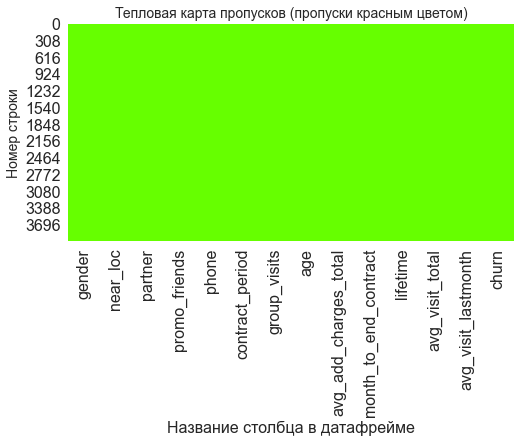

In [11]:
# тепловая карта, для общей визуализации количества пропусков
# зеленым цветом (#66ff00) - непропущенные, красным цветом (#d41243) - пропущенные данные 
colors = ['#66ff00', '#d41243'] 
fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(gym.isna(), cmap=sns.color_palette(colors), cbar=False, ax=ax)
plt.xlabel('Название столбца в датафрейме', fontsize=16)
plt.ylabel('Номер строки', fontsize=14)
plt.title('Тепловая карта пропусков (пропуски красным цветом)', fontsize=14)
plt.show()

# полезная шпаргалка по heatmap https://likegeeks.com/seaborn-heatmap-tutorial/

### 1.1 Проверка соответствия типа данных содержимому <a id="dtypes">
**Краткие выводы:**
    
В целом типы данных соответствуют содержимому. Т.к. `month_to_end_contract` принимает только целочисленные значения, то логично изменить ему тип данных на int64._
    
Столбцы с категориальными данными с возможными значениями 1 и 0:  
`gender`, `near_loc`, `partner`, `promo_friends`, `phone`, `group_visits`, `churn`
    
Столбец с категориальными данными  с возможными значениями 1, 3, 6, 12 `contract_period`

Столбцы с числовыми данными:  
`age`, `avg_add_charges_total`, `avg_visit_total`, `avg_visit_lastmonth`, `lifetime`, `month_to_end_contract`

In [12]:
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int64')

In [13]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 4000 non-null   int64  
 1   near_loc               4000 non-null   int64  
 2   partner                4000 non-null   int64  
 3   promo_friends          4000 non-null   int64  
 4   phone                  4000 non-null   int64  
 5   contract_period        4000 non-null   int64  
 6   group_visits           4000 non-null   int64  
 7   age                    4000 non-null   int64  
 8   avg_add_charges_total  4000 non-null   float64
 9   month_to_end_contract  4000 non-null   int64  
 10  lifetime               4000 non-null   int64  
 11  avg_visit_total        4000 non-null   float64
 12  avg_visit_lastmonth    4000 non-null   float64
 13  churn                  4000 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


In [14]:
# на наличие NaN значений, в относительном выражении (если пропустили глазками)
gym.isna().mean() 

gender                   0.0
near_loc                 0.0
partner                  0.0
promo_friends            0.0
phone                    0.0
contract_period          0.0
group_visits             0.0
age                      0.0
avg_add_charges_total    0.0
month_to_end_contract    0.0
lifetime                 0.0
avg_visit_total          0.0
avg_visit_lastmonth      0.0
churn                    0.0
dtype: float64

In [15]:
# на наличие пропусков как строковых значений
gym.isin(['-', 'None', 'Null', ' ']).sum()

gender                   0
near_loc                 0
partner                  0
promo_friends            0
phone                    0
contract_period          0
group_visits             0
age                      0
avg_add_charges_total    0
month_to_end_contract    0
lifetime                 0
avg_visit_total          0
avg_visit_lastmonth      0
churn                    0
dtype: int64

### 1.3 Проверка на наличие дубликатов <a id="duplicates">
**Краткие выводы:** 
Полных дубликатов нет, все ок

In [16]:
gym.duplicated().sum()

0

### 1.4 Выводы  по разделу<a id="conclusions_1">
В датафрейме пропуски и дубликаты отсутствуют, тип данных для `month_to_end_contract` заменен на целочисленный, в датафрейме присутствуют как числовые, так и категориальные переменные.

## 2. Исследовательский анализ данных (EDA)<a id="eda">

### 2.1 Средние значения признаков и их стандартные отклонения <a id="avg_std_features">
**Краткие выводы:** 
- среди посетителей фитнес центра примерно поровну мужчин и женщин, средний возраст около 29 лет, большая часть клиентов (85%) живет или работает поблизости, примерно половина (49%) клиентов являются сотрудниками компании-партнёра клуба, только треть клиентов пришла по промо-коду, для большинства (90%) указан контактный номер телефона и примерно 41% посещают групповые тренировки;
- в среднем длительность текущего действующего абонемента клиента составляет 4.7 месяца;
-  суммарная выручка от других услуг фитнес-центра в среднем составляет 147 руб, при этом она сильно разнится от клиента к клиенту (стандартное отклонение 96 руб);
- средняя частота посещений в неделю за все время 1.88 раза (при стандартном отклонении 0.97). Есть фанаты которые ходят 6.14 раза в неделю, т.е. почти каждый день;
- при этом аномальных значений (выбросов) по данным признакам нет.

In [17]:
for col in gym.columns:
    print(gym[col].describe())  

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_loc, dtype: float64
count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64
count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64
count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64
count 

### 2.2 Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался<a id="avg_churn">
**Краткие выводы:**
- для группы тех, кто ушел в отток более характерны меньший средний возраст (27 против 30 лет);
- а также меньшие расходы, примерно на 27%, на дополнительные услуги фитнес-центра;
- более редкие в общем посещения - реже в 1.3 раза по сравнению с группой тех, кто остался;
- особенно редкие посещения в последний месяц - реже почти в 2 раза по сравнению с группой тех, кто остался. 

In [18]:
# посмотрим на сводную таблицу средних значений признаков для обеих групп
gym.pivot_table(index='churn',
               values=['age', 
                        'avg_add_charges_total',
                        'avg_visit_total', 
                        'avg_visit_lastmonth'],
               aggfunc='mean')

,age,avg_add_charges_total,avg_visit_lastmonth,avg_visit_total
churn,,,,
0,29.976523,158.445715,2.027882,2.024876
1,26.989632,115.082899,1.044546,1.474995


In [19]:
# определим функцию отрисовки боксплотов для указанного признака
def show_boxplot(data, feature, hue):
    plt.figure(figsize = (10,5))
    g = sns.boxplot(data=data, x=hue, y=feature, hue=hue, dodge=False)
    g.set(xticklabels=[]) # убираем подписи по оси Х
    g.set_xlabel("Ушел ли клиент в отток", fontsize=16)
    g.set_ylabel("")
    g.axes.set_title('Разброс значений для признака: {} '.format(feature), fontsize=18)
    #plt.savefig('', transparent=True)
    plt.legend(fontsize=14)
    plt.show()

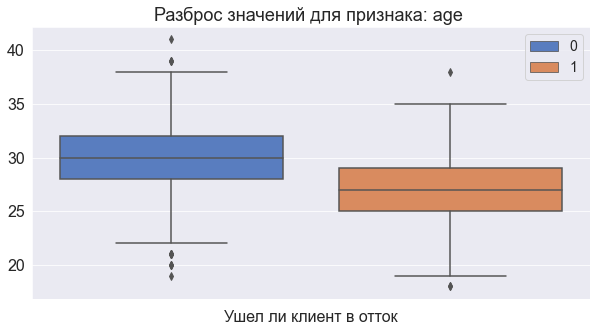

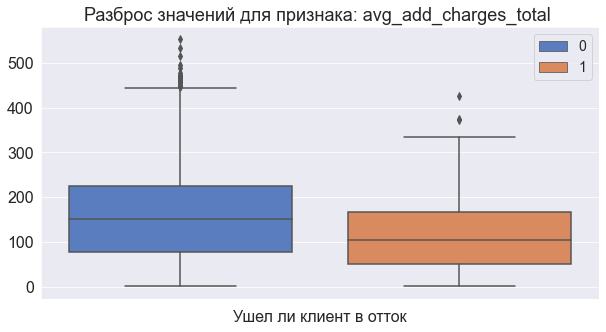

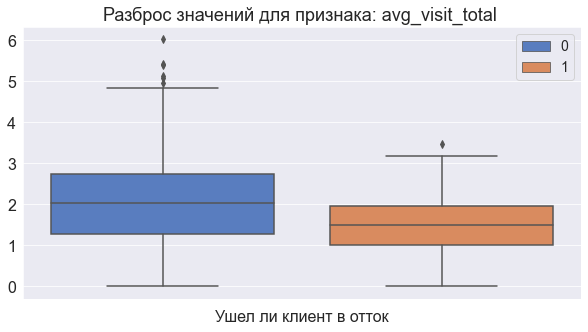

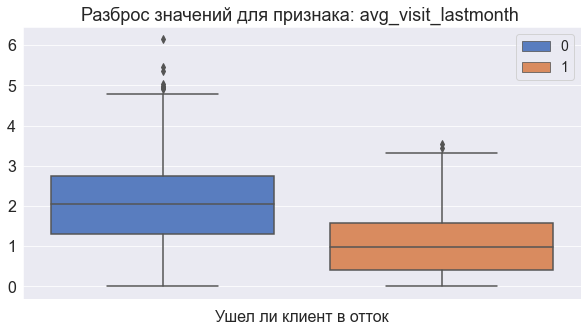

In [20]:
for col in ['age', 'avg_add_charges_total', 
            'avg_visit_total', 'avg_visit_lastmonth']:
    show_boxplot(data=gym, feature=col, hue='churn')

### 2.3 Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)<a id="hist_churn">
**Краткие выводы:**
- распределения числовых признаков для тех, кто ушел (показано красным цветом) смещено влево, в сторону меньших значений относительно тех, кто остался (показано голубым цветом). Особенно сильно отличается вид распределения для суммарной выручки от других услуг фитнес-центра _(avg_add_charges_total)_ и средней частоты посещений за последний месяц _(avg_visit_lastmonth)_;
- для категориальных признаков можно отметить, что для группы тех, кто остался (stayed) характерны:
  - большее количество людей живущих или работающих поблизости;
  - большее количество сотрудников из компании-партнёра клуба;
  - для этих людей указан номер контактного телефона;
  - длительный договор _contract_period_ (на 6 и 12 месяцев); скорее всего, именно наличие долгосрочного договора удерживает людей в фитнес-центре;
  - чаще посещают груповые тренировки;
- при этом пол почти не влияет, в группах кто остался (stayed) и тех, кто ушел (left ~for dead~) примерно одинаковое количество мужчин и женщин.

In [21]:
# сохраним признаки для отдельно тех, кто остался:
churn_no = gym[gym['churn'] == 0]

# тех, кто ушёл в отток:
churn_yes = gym[gym['churn'] == 1]

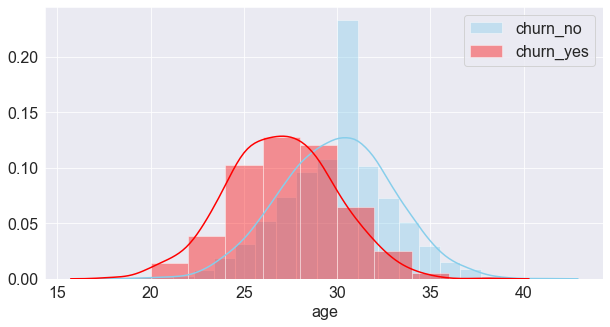

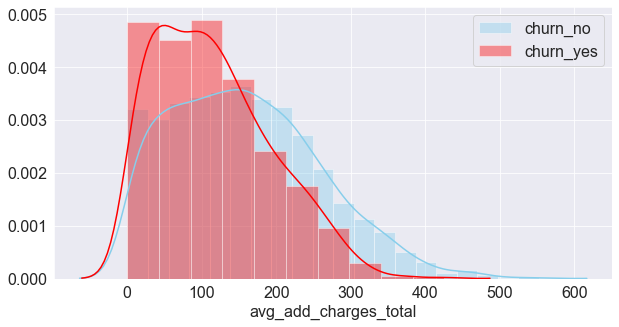

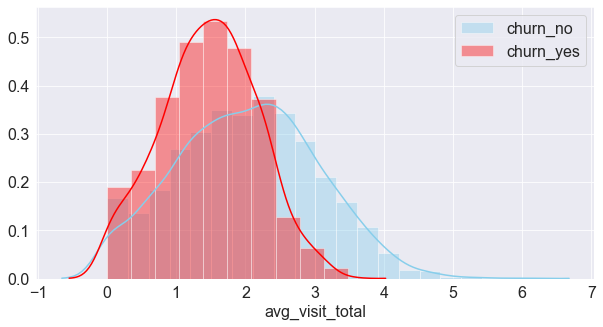

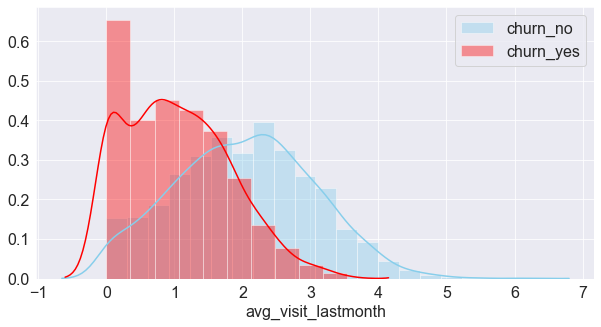

In [22]:
for feature in ['age', 'avg_add_charges_total', 'avg_visit_total', 'avg_visit_lastmonth']:
    plt.figure(figsize = (10,5))
    g = sns.distplot(churn_no[feature] , color='skyblue', bins =20, label='churn_no')
    g = sns.distplot(churn_yes[feature], color='red', bins =10, label='churn_yes')
    g.set_xlabel(feature, fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

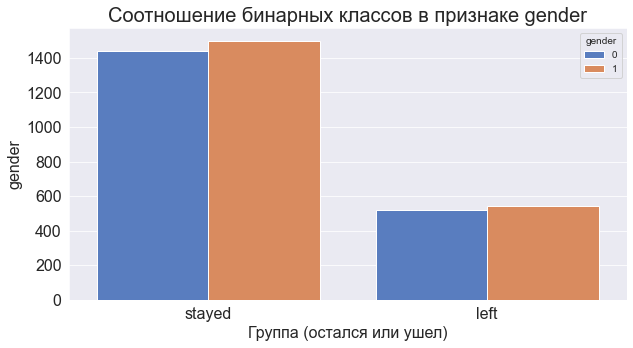

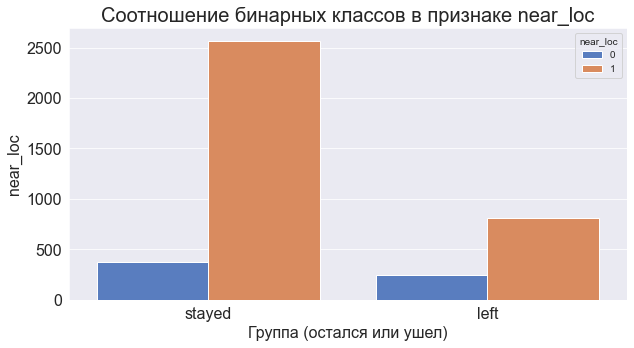

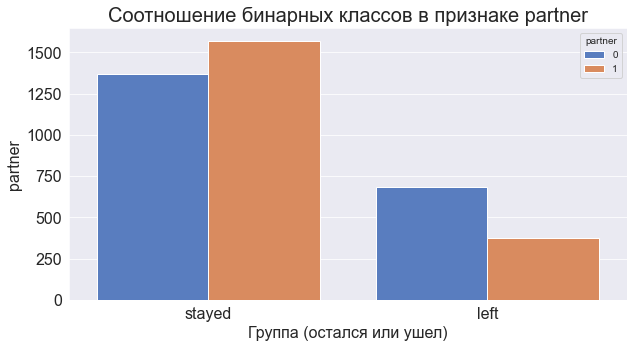

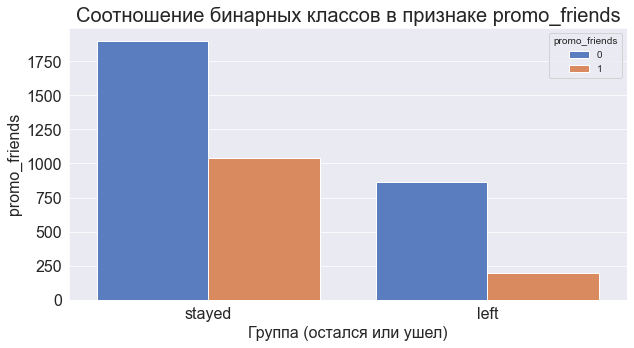

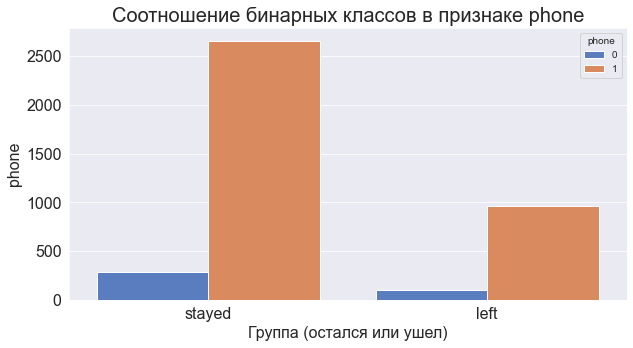

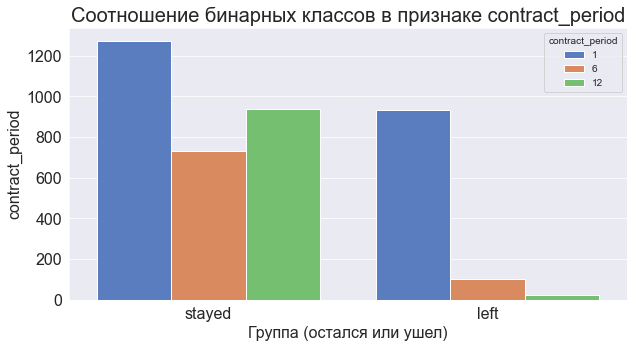

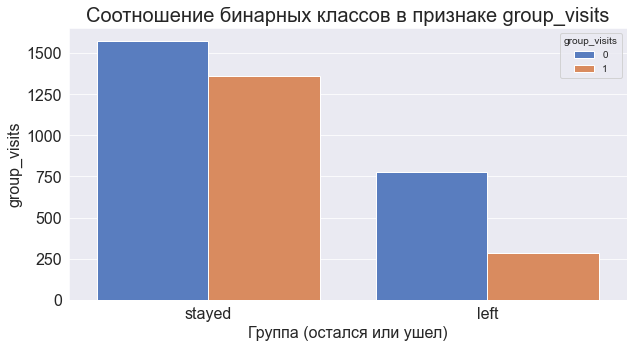

In [23]:
# посмотрим разбивку по категориальным признакам для групп (остался или ушел)
gym_churn_rename = gym.copy()
gym_churn_rename['churn'] = gym_churn_rename['churn'].replace(0, 'stayed')
gym_churn_rename['churn'] = gym_churn_rename['churn'].replace(1, 'left')

for feature in ['gender', 'near_loc', 'partner', 'promo_friends', 'phone', 'contract_period',
       'group_visits']:
    plt.figure(figsize=(10, 5))
    g = sns.countplot(x='churn', data=gym_churn_rename, hue=feature)
    g.set_xlabel('Группа (остался или ушел)',fontsize=16)
    g.set_ylabel(feature,fontsize=16)
    g.axes.set_title("Соотношение бинарных классов в признаке " + feature, fontsize=20)
    plt.show()

### 2.4 Матрица корреляций<a id="matrix_corr">

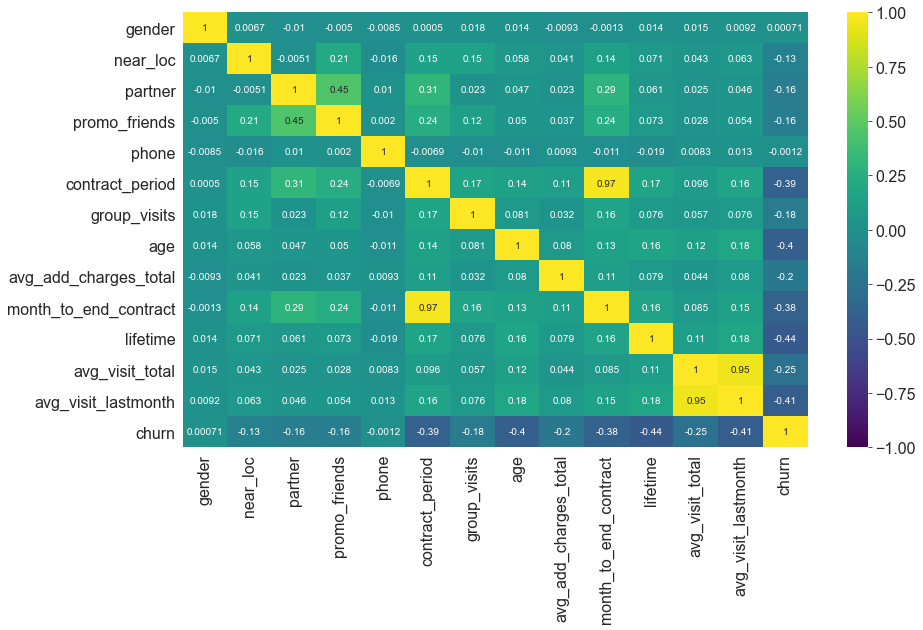

In [24]:
# строим матрицу корреляция для признаков
corr_matrix = gym.corr()

plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix, cmap='viridis', vmin=-1, vmax=1,  annot=True)
plt.show()

Значимой корреляции целевой переменной с каким либо признаком не наблюдаем. Зато видим, что сильно коррелируют между собой `contract_period` и `month_to_end_contract`, а также `avg_visit_total` и `avg_visit_lastmonth`. Поэтому перед построением модели избавимся от этой мультиколлинеарности:

In [25]:
gym_filtered = gym.drop(['contract_period', 'avg_visit_lastmonth'], axis=1)

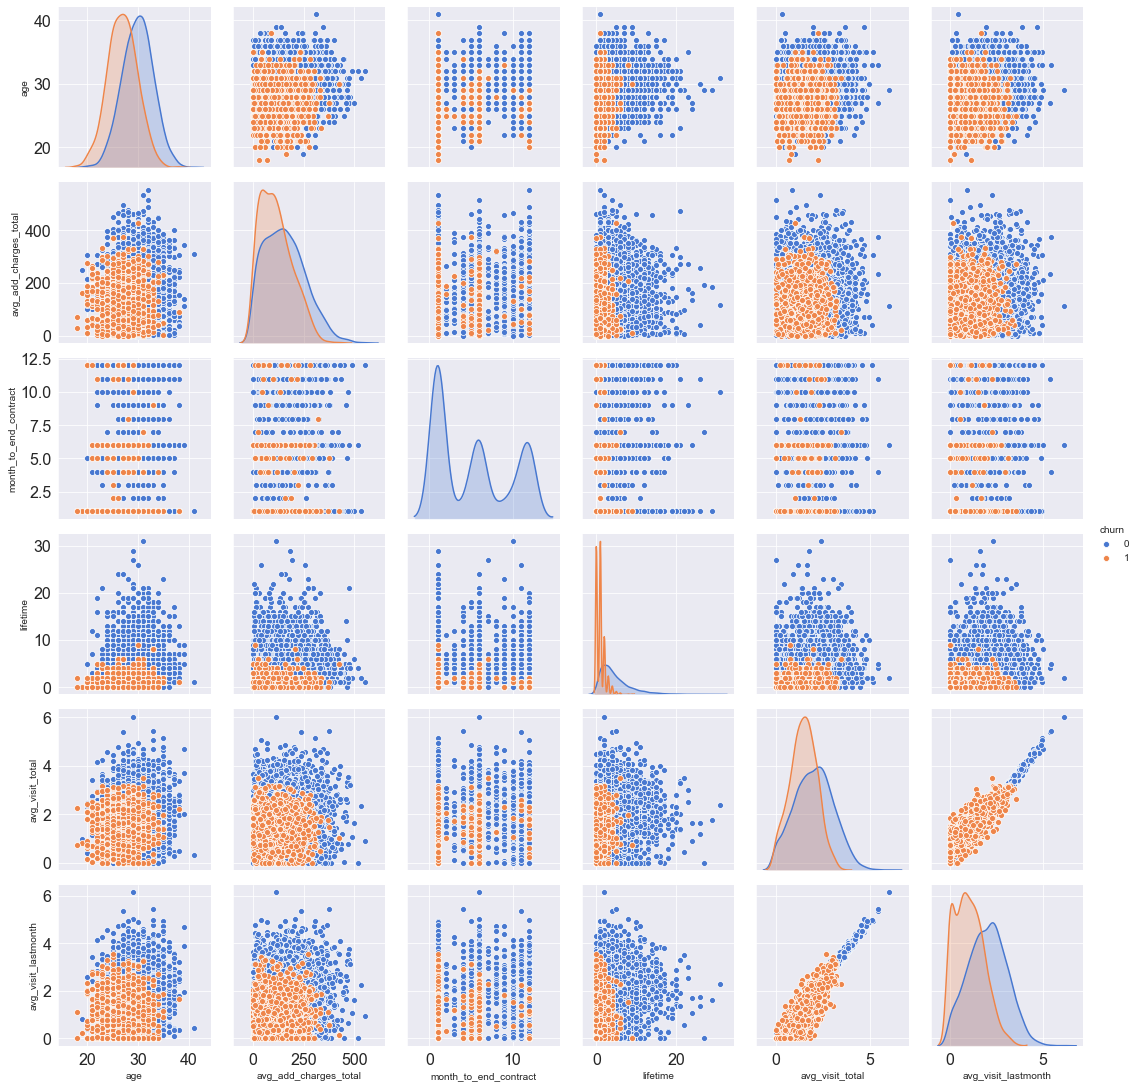

In [26]:
sns.pairplot(gym[['age', 'avg_add_charges_total', 'month_to_end_contract', 'lifetime', 'avg_visit_total',
       'avg_visit_lastmonth', 'churn']], hue='churn')

### 2.5 Выводы по разделу<a id="conclusions_2">
- среди посетителей фитнес центра преобладают люди среднего возраста около 29 лет;
-  суммарная выручка от других услуг фитнес-центра в среднем 147 руб, при этом она сильно разнится от клиента к клиенту;
- средняя частота посещений в неделю за все время 1.88 раза. Есть фанаты которые ходят 6.14 раза в неделю, т.е. почти каждый день;
- для группы тех, кто ушел в отток более характерны меньший средний возраст (27 против 30 лет);
- меньшие расходы, примерно на 27%, на дополнительные услуги фитнес-центра;
- более редкие в общем посещения - реже в 1.3 раза по сравнению с группой тех, кто остался;
- особенно редкие посещения в последний месяц - реже почти в 2 раза по сравнению с группой тех, кто остался. 
- для категориальных признаков можно отметить, что для группы тех, кто остался (stayed) характерны:
  - большее количество людей живущих или работающих поблизости;
  - большее количество сотрудников из компании-партнёра клуба;
  - для этих людей указан номер контактного телефона;
  - длительный договор _contract_period_ (на 6 и 12 месяцев); скорее всего, именно наличие долгосрочного договора удерживает людей в фитнес-центре;
  - чаще посещают групповые тренировки;
- при этом пол почти не влияет, в группах кто остался (stayed) и тех, кто ушел (left ~for dead~) примерно одинаковое количество мужчин и женщин.


## 3. Модель прогнозирования оттока пользователей<a id="model">
Т.к. для фитнес-центра важнее выявить всех клиентов, которые собираются уйти для активизации работы с ними, чем ошибиться и ни в коем случае не решить, что лояльный клиент собрался уходить, то приоритетной метрикой
является полнота _Recall_.
    
При этом каждое срабатывание модели (факт отнесения к классу "1") для фитнес-центра стоит, скорее всего, небольших денег в виде дополнительной работы отдела маркетинга на и так лояльных клиентов (т.е. которые и не собирались уходить). Таким образом, можно себе позволить, чтобы модель часто "срабатывала попусту" (высокое значение False Positive), следовательно, метрика _Precision_ здесь не так важна.

In [27]:
# Разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_filtered.drop('churn', axis = 1)
y = gym_filtered['churn']

In [28]:
# посмотрим, как соотносятся классы в наборе данных
print('Соотношение классов:\n', gym_filtered['churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


Т.к. баланс классов в целевой переменной (класс "0" к классу "1") слабый 73% : 27%, то задаем своё пороговое значение при определении бинарных классов. И таким образом корректируем наиболее важную для нас метрику _Recall_. 

### 3.1 Логистическая регрессия (с дефолтным и кастомным порогами)<a id="lr_model">

In [29]:
# разделим данные на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, stratify=y)

# зададим алгоритм для модели логистической регрессии
# расширяю лимит на количество итераций, т.к. при дефолтном значении 100, решение не сходится
lr_model = LogisticRegression(max_iter=400, solver = 'lbfgs')
# обучим модель
lr_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
probabilities = lr_model.predict_proba(X_test)[:,1]

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test)
print('Метрики для модели логистической регрессии с дефолтным порогом 0.5:')
print('accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}'.format(
                            accuracy_score(y_test, lr_predictions), 
                            precision_score(y_test, lr_predictions),
                            recall_score(y_test, lr_predictions)))

# задаем порог
threshold = .2

# откорректируем предсказания для нового порогового значения
# если вероятность выше нового порога, то присваиваем класс "1"
custom_predictions = np.where(lr_model.predict_proba(X_test)[:,1] > threshold, 1, 0)

print('Метрики для модели логистической регрессии с порогом {}:'.format(threshold))
print('accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}'.format(
                              accuracy_score(y_test, custom_predictions), 
                              precision_score(y_test, custom_predictions),
                              recall_score(y_test, custom_predictions)))

Метрики для модели логистической регрессии с дефолтным порогом 0.5:
accuracy: 0.90, precision: 0.81, recall: 0.83
Метрики для модели логистической регрессии с порогом 0.2:
accuracy: 0.87, precision: 0.69, recall: 0.95


In [30]:
# по матрице ошибок смотрим, как именно склонен ошибаться алгоритм
cm = confusion_matrix(y_test, custom_predictions)

# "выпрямляем" матрицу, чтобы вытащить нужные значения
tn, fp, fn, tp = cm.ravel() 

print('Всего наблюдений в валидационной выборке y_test:', len(y_test))
print('''Значение TN: {}
Значение FP: {}
Значение FN: {}
Значение TP: {}'''.format(tn, fp, fn, tp))
# если много FP - чрезмерный оптимизм, если много FN - избыток пессимизма

Всего наблюдений в валидационной выборке y_test: 800
Значение TN: 496
Значение FP: 92
Значение FN: 10
Значение TP: 202


### 3.2 Случайный лес<a id="rf_model">

In [31]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
print('Метрики для модели случайного леса')
print('accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}'.\
                            format(accuracy_score(y_test, rf_predictions), 
                            precision_score(y_test, rf_predictions),
                            recall_score(y_test, rf_predictions)))

Метрики для модели случайного леса
accuracy: 0.90, precision: 0.83, recall: 0.79


### 3.3 Выводы по разделу<a id="conclusions_3">
- Для фитнес-центра важнее выявить всех клиентов, которые собираются уйти для активизации работы с ними, чем ошибиться и ни в коем случае не решить, что лояльный клиент собрался уходить, поэтому приоритетной метрикой
выбрана полнота _Recall_.
- Наибольшей полнотой (recall = 0.95) обладает модель логистической регрессии с кастомным порогом. Модель на основе алгоритма случайного леса обладает полнотой в 0.79.
- При этом все три модели показывают высокую accuracy на уровне 0.87-0.90, выше чем у простейшей модели (которая всем будет говорить "он станется" и для баланса классов 73% : 27% даст accuracy в 0.73). 

## 4. Кластеризация пользователей<a id="cluster">

### 4.1 Древовидная кластеризация<a id="dendrogram">

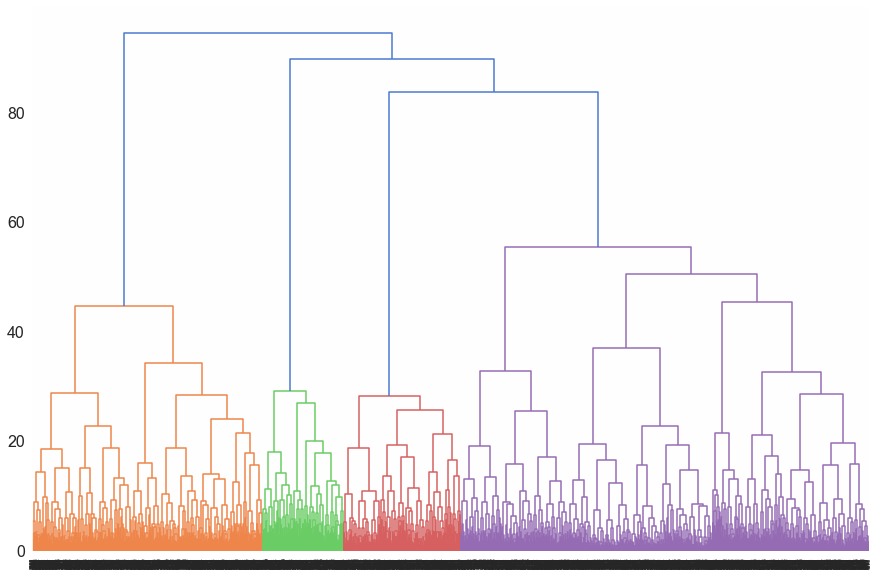

In [32]:
# обязательная стандартизация данных перед работой
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

linked = linkage(X_scaled, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

- Можно выделить 4 кластера — четыре разных цвета на графике.

### 4.2 Кластеризация K-means<a id="K_means">
- берем предложенное в задании число кластеров 5

In [33]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений
clusters = km.fit_predict(X_scaled)

# сохраняем метки кластера в поле нашего датасета
gym['cluster'] = clusters
gym.sample(5)

,gender,near_loc,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_visit_total,avg_visit_lastmonth,churn,cluster
313,1,1,1,0,1,1,1,26,300.927987,1,2,2.383708,2.214755,0,2
424,1,1,0,0,1,1,0,29,100.861581,1,1,1.631407,1.591883,1,4
3669,0,1,0,0,1,1,0,26,47.199104,1,1,2.691318,2.148767,1,4
241,0,0,0,0,1,1,0,27,185.210885,1,6,0.740678,0.672148,0,1
168,1,1,1,0,0,1,0,26,24.506480,1,5,0.810200,0.049767,1,0


In [34]:
# выводим статистику по средним значениям наших признаков по кластеру
gym_avg = gym.groupby('cluster').mean().round(2)
gym_avg

,gender,near_loc,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_visit_total,avg_visit_lastmonth,churn
cluster,,,,,,,,,,,,,,
0,0.52,0.86,0.47,0.31,0.0,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
1,0.50,0.00,0.49,0.08,1.0,3.03,0.24,28.72,137.54,2.85,3.06,1.77,1.61,0.40
2,1.00,1.00,0.87,0.64,1.0,6.34,0.47,29.47,148.88,5.77,4.21,1.90,1.82,0.17
3,0.00,1.00,0.91,0.64,1.0,6.19,0.45,29.30,153.33,5.67,4.01,1.94,1.88,0.18
4,0.52,1.00,0.00,0.00,1.0,3.41,0.42,29.09,146.50,3.19,3.47,1.88,1.75,0.32


- Видим, что для 5 предложенных кластеров есть значительные отличия в средних значениях. Построим боксплоты и гистгораммы и сделаем выводы по каждому кластеру ниже.

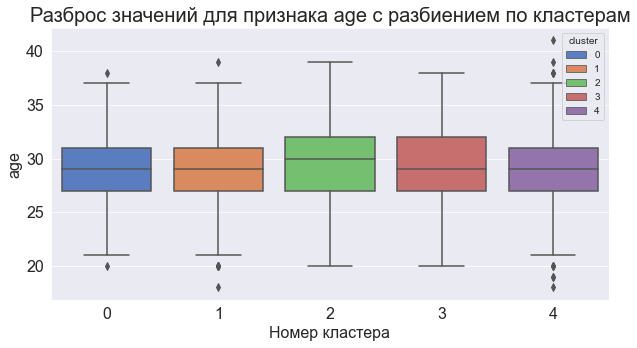

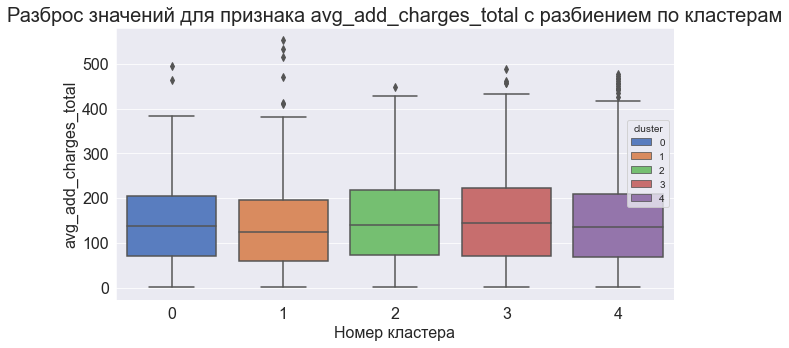

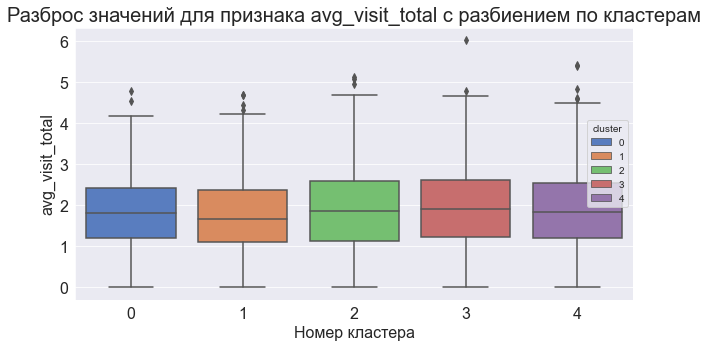

In [35]:
for feature in ['age', 'avg_add_charges_total', 'avg_visit_total']:
    plt.figure(figsize=(10, 5))
    g = sns.boxplot(x='cluster', y=feature, hue='cluster', data=gym, dodge=False)
    g.set_xlabel('Номер кластера',fontsize=16)
    g.set_ylabel(feature,fontsize=16)
    g.axes.set_title("Разброс значений для признака " + feature + " с разбиением по кластерам",fontsize=20)
    plt.show()

- Кластеры слабо отличаются между собой по числовым признакам, посмотрим что с категориальными:

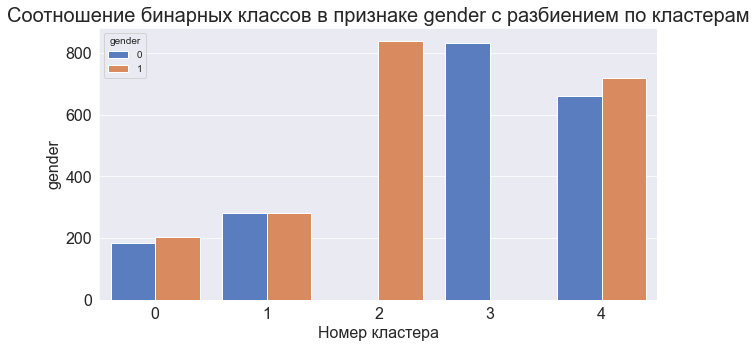

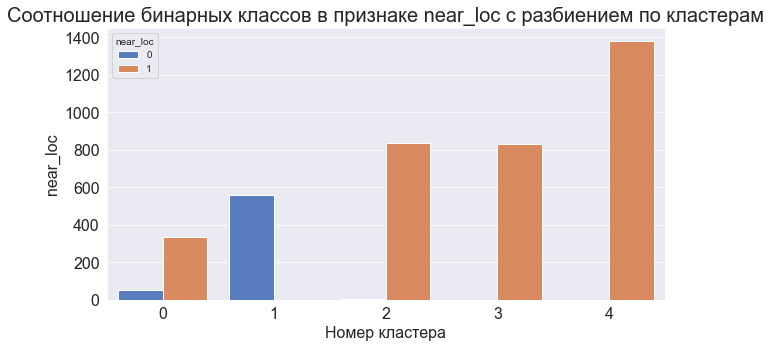

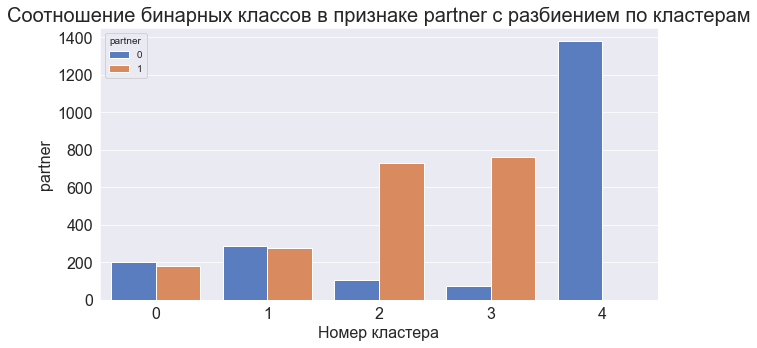

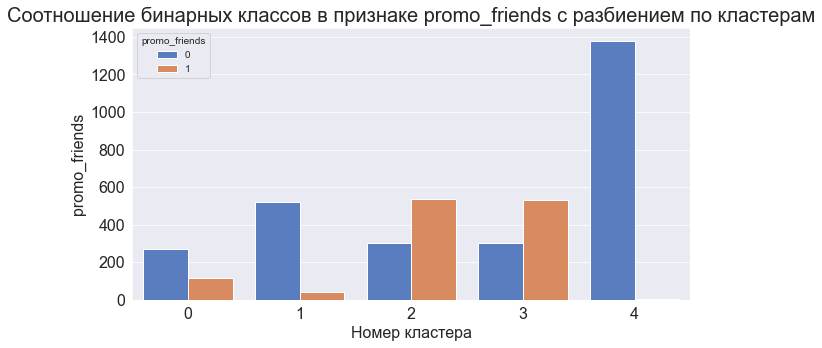

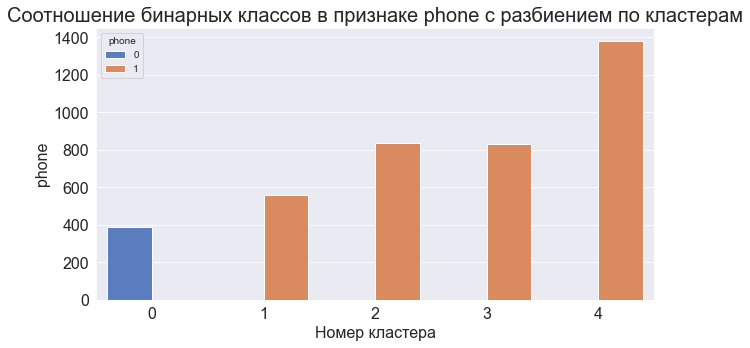

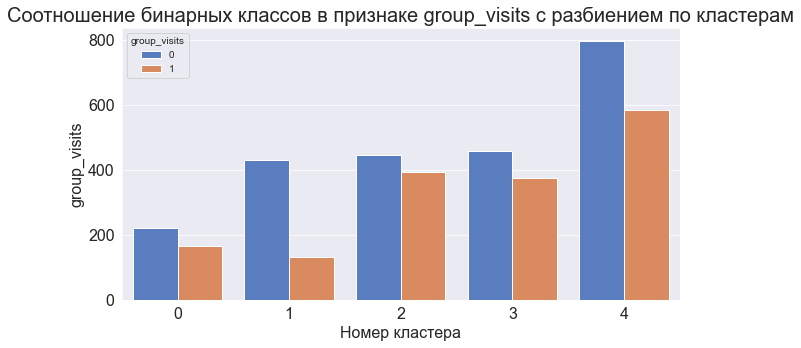

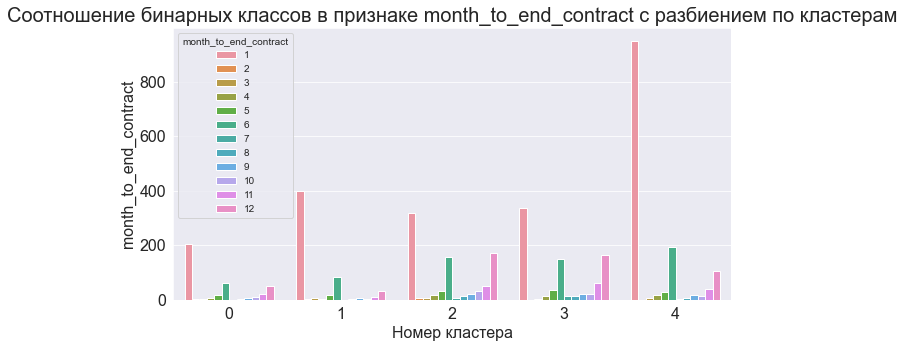

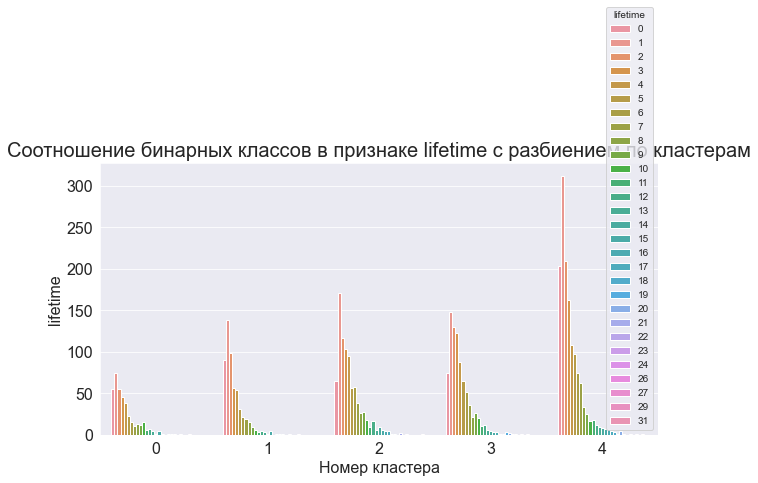

In [36]:
for feature in ['gender', 'near_loc', 'partner', 'promo_friends', 'phone',
       'group_visits', 'month_to_end_contract', 'lifetime']:
    plt.figure(figsize=(10, 5))
    g = sns.countplot(x='cluster', data=gym, hue=feature)
    g.set_xlabel('Номер кластера',fontsize=16)
    g.set_ylabel(feature,fontsize=16)
    g.axes.set_title("Соотношение бинарных классов в признаке " + feature + " с разбиением по кластерам", fontsize=20)
    plt.show()

In [37]:
# Для каждого полученного кластера посчитаем долю оттока
gym_avg.sort_values(by='churn', ascending=False)

,gender,near_loc,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_visit_total,avg_visit_lastmonth,churn
cluster,,,,,,,,,,,,,,
1,0.50,0.00,0.49,0.08,1.0,3.03,0.24,28.72,137.54,2.85,3.06,1.77,1.61,0.40
4,0.52,1.00,0.00,0.00,1.0,3.41,0.42,29.09,146.50,3.19,3.47,1.88,1.75,0.32
0,0.52,0.86,0.47,0.31,0.0,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
3,0.00,1.00,0.91,0.64,1.0,6.19,0.45,29.30,153.33,5.67,4.01,1.94,1.88,0.18
2,1.00,1.00,0.87,0.64,1.0,6.34,0.47,29.47,148.88,5.77,4.21,1.90,1.82,0.17


- наибольший отток (0.4 или 40%) в кластере №1, на втором месте кластер №4 с оттоком 32%, на третьем месте кластер №0 с оттоком в 27%

### 4.3 Характерные портреты клиентов фитнес-центра<a id="client_portreit">

Для кластера 0 характерно:
  - равное соотношение мужчин и женщин;
  - большее количество людей живущих и работающих поблизости;
  - примерно равное количество сотрудников из партнеров клуба и не партнеров;
  - большее количество людей пришли без промо-кода;
  - не указан номер контактного телефона;
  - примерно одинаковое количество людей посещает и не посещает групповые тренировки;

Для кластера 1 характерно:
  - равное соотношение мужчин и женщин;
  - состоит только из людей из далеких, не близлежащих районов;
  - примерно равное количество сотрудников из партнеров клуба и не партнеров;
  - большее количество людей пришли без промо-кода;
  - указан номер контактного телефона;
  - большее количество людей посещат групповые тренировки;

Для кластера 2 характерно:
  - состоит только из мужчин;
  - состоит только из людей живущих и работающих поблизости;
  - значительно большее количество сотрудников из партнеров клуба;
  - большее количество людей пришедших по промо-коду;
  - указан номер контактного телефона;
  - примерно одинаковое количество людей посещает и не посещает групповые тренировки;
  - большее количество людей у которых договор действует от 6 до 12 месяцев;

Для кластера 3 характерно:
  - состоит только из женщин;
  - состоит только из людей живущих и работающих поблизости;
  - значительно большее количество сотрудников из партнеров клуба;
  - большее количество людей пришедших по промо-коду;
  - указан номер контактного телефона;
  - примерно одинаковое количество людей посещает и не посещает групповые тренировки;

Для кластера 4 характерно:
  - равное соотношение мужчин и женщин;
  - состоит только из людей живущих и работающих поблизости;
  - состоит только из не партнеров клуба;
  - все люди из этого кластера пришли без промо-кода;
  - указан номер контактного телефона;
  - примерно одинаковое количество людей посещает и не посещает групповые тренировки;

### 4.3 Выводы по разделу<a id="conclusions_4">
Клиентов фитнес-центра можно разбить на 4-5 кластеров, для каждого кластера составлен свой портрет, наибольший отток 40% в кластере №1, на втором месте кластер №4 с оттоком 32%, на третьем месте кластер №0 с оттоком в 27%.

## 5. Выводы и базовые рекомендации по работе с клиентами<a id="summary">
Таким образом, отделу маркетинга можно порекомендовать:
- создать систему по отслеживанию и выделению людей у которых снижается частота посещений, а также снижаются расходы на дополнительные услуги фитнес-центра. При достижении пороговых критических значений данных показателей начать дополнительную работу с данными клиентами;
- при заключении договора настаивать на длительном договоре от 6 месяцев (делать скидки на годовые абонементы), а также запрашивать контактный номер телефона;
- втягивать клиента в групповые тренировки (только не преступным путем:)